# Módulos

In [1]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import scipy as sp

# Lectura de datos

In [2]:
datos = pd.read_csv('DatosLimpiosOilWell')

In [35]:
datos.rename(columns={datos.columns[0] : 'Fecha'}, inplace=True)
datos.index = pd.to_datetime(datos['Fecha'])

# OilVol

<Axes: ylabel='OilVol'>

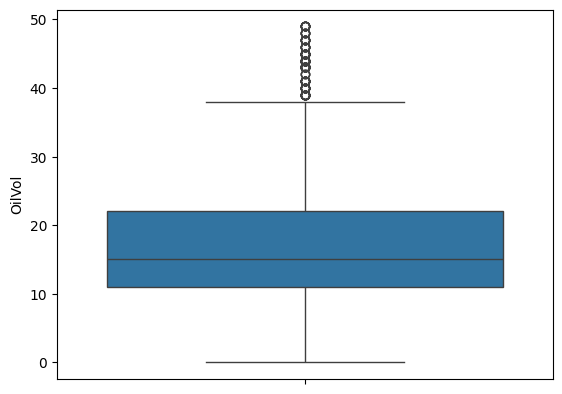

In [25]:
# sns.boxplot(datos['OilVol'])

In [38]:
OilVol = datos['OilVol']
# OilVol.set_index(datos['Fecha'])

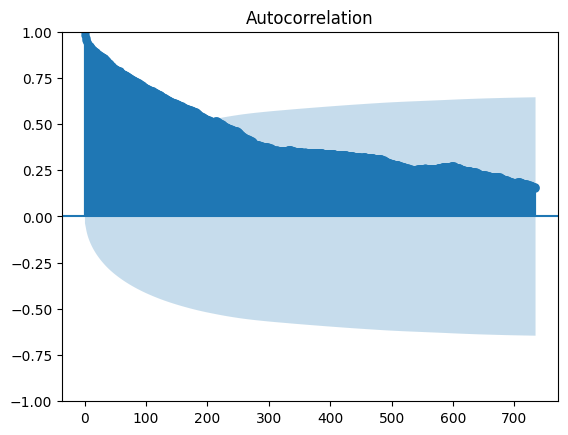

In [47]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(OilVol,lags= 2939/4)
plt.show()

## MLP

### División de datos

Vamos a configurar el problema de aprendizaje supervisado, se usaran los últimos 17 retardos de la misma variable para predecir un año

In [127]:
from pandas import DataFrame

df1 = DataFrame()
print(df1)

Empty DataFrame
Columns: []
Index: []


In [128]:
for i in range(17,0,-1):
    df1['t-'+str(i)] = OilVol.shift(i)

In [129]:
# Creando la columna para t 365

In [130]:
df1['t+365'] = OilVol.shift(-364)

In [131]:
df1.dropna(inplace=True)

In [132]:
df1

,t-17,t-16,t-15,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t+365
Fecha,,,,,,,,,,,,,,,,,,
2013-01-18,49.0,49.0,49.0,49.0,44.0,44.0,43.0,43.0,43.0,43.0,43.0,42.0,43.0,43.0,44.0,44.0,44.0,24.0
2013-01-19,49.0,49.0,49.0,44.0,44.0,43.0,43.0,43.0,43.0,43.0,42.0,43.0,43.0,44.0,44.0,44.0,44.0,25.0
2013-01-20,49.0,49.0,44.0,44.0,43.0,43.0,43.0,43.0,43.0,42.0,43.0,43.0,44.0,44.0,44.0,44.0,46.0,25.0
2013-01-21,49.0,44.0,44.0,43.0,43.0,43.0,43.0,43.0,42.0,43.0,43.0,44.0,44.0,44.0,44.0,46.0,46.0,25.0
2013-01-22,44.0,44.0,43.0,43.0,43.0,43.0,43.0,42.0,43.0,43.0,44.0,44.0,44.0,44.0,46.0,46.0,44.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-15,8.0,8.0,8.0,7.0,9.0,7.0,7.0,8.0,8.0,7.0,6.0,7.0,6.0,6.0,7.0,7.0,6.0,5.0
2020-01-16,8.0,8.0,7.0,9.0,7.0,7.0,8.0,8.0,7.0,6.0,7.0,6.0,6.0,7.0,7.0,6.0,6.0,6.0
2020-01-17,8.0,7.0,9.0,7.0,7.0,8.0,8.0,7.0,6.0,7.0,6.0,6.0,7.0,7.0,6.0,6.0,7.0,6.0


Ahora se dividirán los datos en la respuesta y las covariables y esta división se partirá en entrenamiento, validación y prueba

In [133]:
df1_m = df1.values #Convierte el data frame a una matriz
X1 = df1_m[: , 0:-1] #Toma todas las covariables
y1 = df1_m[: , -1]


Primero se dividirán los datos en 2: 
1. 90% para entrenamiento.
2. 10% para prueba.

Luego se dividirá el conjunto de entrenamiento en entrenamiento y validación:

1. 80% del 90% para entrenamiento
2. 20% del 90% para prueba

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [135]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X1 , y1 , test_size = 0.1, train_size = 0.9, shuffle = False)

In [136]:
print(X_train_full.shape)
print(X_test.shape)

print(y_train_full.shape)
print(y_test.shape)

(2302, 17)
(256, 17)
(2302,)
(256,)


In [137]:
X_train, X_val, y_train, y_val =train_test_split(X_train_full, y_train_full, test_size = 0.2, train_size = 0.8, shuffle = False)

In [140]:
print(X_train.shape)
print(X_val.shape)

print(y_train.shape)
print(y_val.shape)

(1841, 17)
(461, 17)
(1841,)
(461,)


In [160]:
1841 + 461 + 256 == df1.shape[0]

True

### Escalar los datos

Se escalarán los datos usando la función **MinMaxScaler** para transformar las covariables entre **0** y **1**. Esta transformación se hace con base en el conjunto de entrenamiento y se aplican los parámetros *Min*, *Max* a los 3 conjuntos, entrenamiento, validación y prueba.

In [164]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)


In [168]:
y_test.shape

(256,)

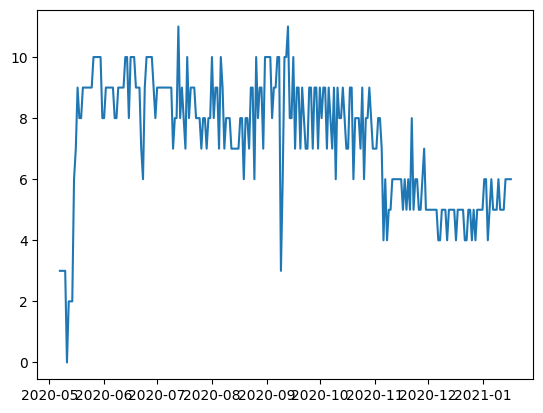

In [176]:
plt.plot(datos.index[-256:], y_test)

### Red neuronal con una sóla capa oculta

In [188]:
import tensorflow.keras as keras

In [189]:
model=keras.models.Sequential([keras.layers.Dense(64,activation="relu",input_shape=X_train.shape[1:]),keras.layers.Dense(1)])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 64)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

In [190]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_val,y_val), batch_size=40)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 314.7477 - val_loss: 37.3011
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 230.0466 - val_loss: 6.2045
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121.1463 - val_loss: 62.5874
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.0257 - val_loss: 180.5888
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.7512 - val_loss: 260.9813
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.0274 - val_loss: 277.5013
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.1151 - val_loss: 280.3024
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 28.0009 - val_loss: 281.1123
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.8781 - val_loss: 277.2672
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.0851 - val_loss: 274.1470
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.0027 - val_loss: 274.2130
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [198]:
X_train.shape[0] / 40 # Este es el número de lotes, i.e. cuando se estiman las 47 lotes completa una época.

46.025

<Axes: >

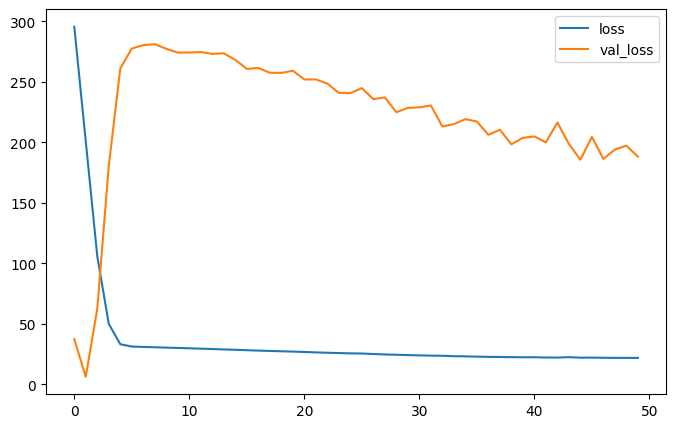

In [199]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [200]:
mse_test=model.evaluate(X_test,y_test)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 116.8216


El riesgo sobre el conjunto de prueba es de **116.8216**!

In [201]:
ypred=model.predict(X_test)
print(ypred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
[[24.60868  ]
 [24.334509 ]
 [23.654762 ]
 [22.785568 ]
 [22.811361 ]
 [22.308329 ]
 [21.283186 ]
 [21.315386 ]
 [21.395716 ]
 [20.571293 ]
 [20.812168 ]
 [20.716425 ]
 [19.966345 ]
 [19.089354 ]
 [19.526205 ]
 [18.219946 ]
 [17.881083 ]
 [18.60226  ]
 [18.25629  ]
 [18.355341 ]
 [18.110956 ]
 [18.604948 ]
 [18.22333  ]
 [18.522562 ]
 [17.860968 ]
 [17.843847 ]
 [18.562565 ]
 [18.89572  ]
 [18.27706  ]
 [18.358335 ]
 [18.169092 ]
 [17.731539 ]
 [18.609015 ]
 [18.748964 ]
 [18.264694 ]
 [18.703438 ]
 [17.685091 ]
 [17.912018 ]
 [17.491869 ]
 [17.78642  ]
 [17.25266  ]
 [18.756544 ]
 [18.701105 ]
 [18.245718 ]
 [18.611147 ]
 [18.342928 ]
 [18.091593 ]
 [18.09368  ]
 [18.279318 ]
 [17.456282 ]
 [17.53592  ]
 [17.114956 ]
 [17.174673 ]
 [17.72161  ]
 [18.361643 ]
 [17.547495 ]
 [17.360498 ]
 [18.370115 ]
 [17.656458 ]
 [18.460142 ]
 [18.418116 ]
 [18.788534 ]
 [18.430006 ]
 [18.686916 ]
 [18.387447 ]
 [18.693865 ]
 [18.541183 ]
 [18.412485 ]
 [18.7744

Text(0.5, 0, 'Index')

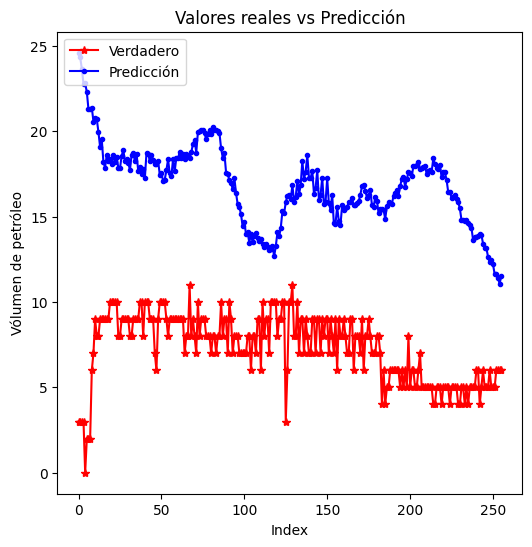

In [203]:
plt.figure(figsize=(6, 6))
plt.plot(range(y_test.size), y_test, linestyle='-', marker='*', color='r')
plt.plot(range(ypred.size), ypred, linestyle='-', marker='.', color='b') 
plt.legend(['Verdadero','Predicción'], loc=2)
plt.title('Valores reales vs Predicción')
plt.ylabel('Vólumen de petróleo')
plt.xlabel('Index')

### Red más compleja